In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os

from scipy.io import loadmat
from skimage.io import imsave

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
import sys

sys.path.append("/mnt/b/Git_Projects/Biospec_Analysis/UNET")
sys.path.append("/mnt/b/Git_Projects/Biospec_Analysis")

import Preprocessing_Methods as pm

In [4]:
data = loadmat(os.path.join(os.getcwd(), 'Tissue FTIR images.mat'))

In [5]:
cells = pm.truncate(pd.read_pickle("/mnt/b/Google_Drive/PhD/DataSets/Oesophageal_raw"))

In [6]:
G1_im = data["G1data"]
G1 = G1_im.reshape(-1, G1_im.shape[-1])
G1 = pm.truncate(pd.DataFrame(G1, columns=data["Wavenumbers"].squeeze().astype(np.int)))

H1_im = data["H1data"]
H1 = H1_im.reshape(-1, H1_im.shape[-1])
H1 = pm.truncate(pd.DataFrame(H1, columns=data["Wavenumbers"].squeeze().astype(np.int)))

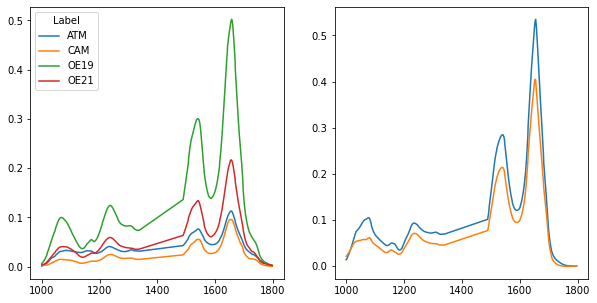

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (10,5))

cells.groupby("Label").mean().T.plot(ax=ax1)
G1.mean().T.plot(ax=ax2)
H1.mean().T.plot(ax=ax2)

In [8]:
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.preprocessing import normalize, robust_scale, minmax_scale
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier


In [17]:
pcapipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
    ("Scaler", RobustScaler()),
    ("PCA", PCA()),
    ("Clf", CalibratedClassifierCV(LinearDiscriminantAnalysis()))
])

In [10]:
h1n = pm.interpolate_DF(H1, cells.columns)
g1n = pm.interpolate_DF(G1, cells.columns)

In [18]:
pcapipe.fit(cells, cells.reset_index()["Label"])

Pipeline(steps=[('Normalise spectra',
                 FunctionTransformer(func=<function robust_scale at 0x7f4a63e6ef70>,
                                     kw_args={'axis': 1})),
                ('Scaler', RobustScaler()), ('PCA', PCA()),
                ('Clf',
                 CalibratedClassifierCV(base_estimator=LinearDiscriminantAnalysis()))])

In [12]:
h1_processed=h1n.values.reshape(H1_im.shape[0], H1_im.shape[1], -1)
g1_processed=g1n.values.reshape(G1_im.shape[0], G1_im.shape[1], -1)


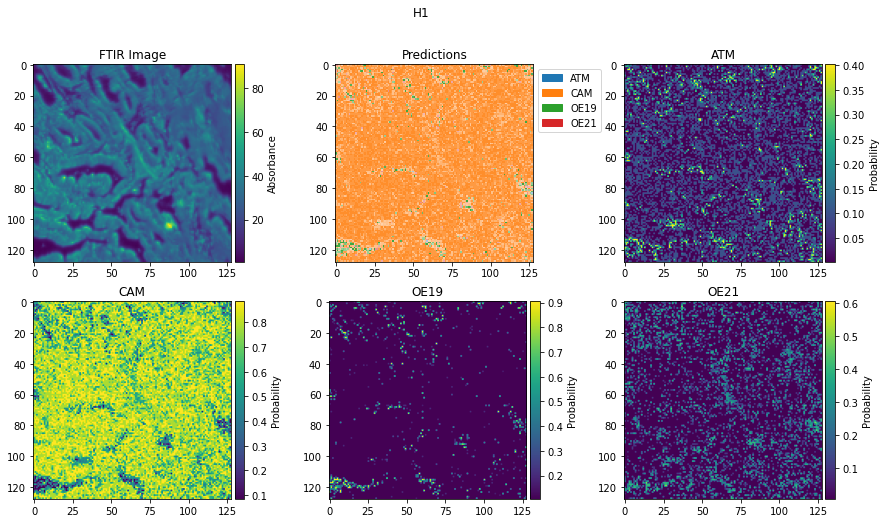

In [19]:
fig = pm.im_classification_plot(pcapipe, h1_processed);
fig.suptitle("H1")
plt.show()

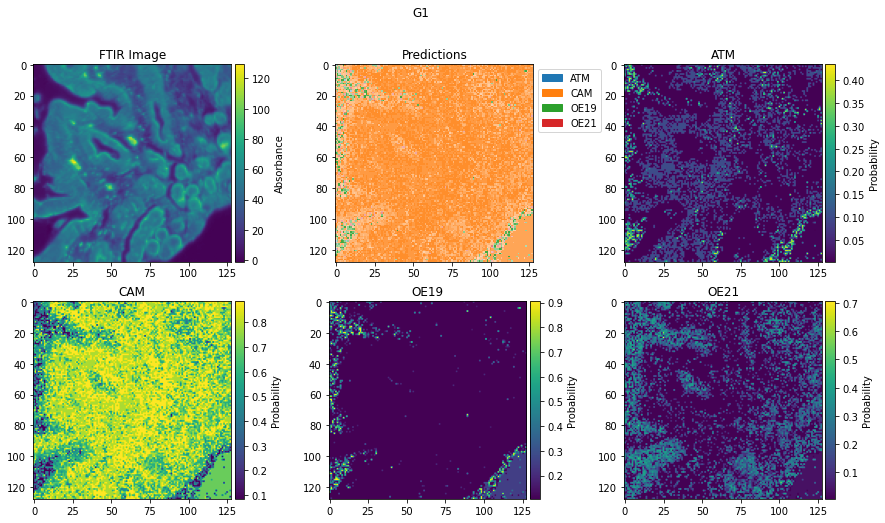

In [20]:
fig = pm.im_classification_plot(pcapipe, g1_processed);
fig.suptitle("G1")
plt.show()